In [100]:
#Brownian motion
%matplotlib inline
import time
import random
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
from numpy import *
import matplotlib as mpl
import matplotlib.cm as cm
from sympy import *
from mpl_toolkits.axes_grid1 import make_axes_locatable
import warnings
from scipy.optimize import OptimizeWarning
import seaborn as sns; import pandas as pd
plt.rcParams.update({'font.size': 14})
import statistics as stats
import os, sys
import statistics 

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

def calcvelocity(rrange,sigma,vdiff,A,vmin):
    sigmaterm = sigma**2
    distances = np.linspace(0,rrange,100)
    I = A*np.exp(-distances**2/sigmaterm)
    return distances, vdiff*np.exp(-I/A)+vmin

def tothecenter(xpos,ypos,angleh):
    value = math.atan(ypos/xpos)*180/math.pi
    if(xpos < 0): angleh = value+180
    else: angleh = value
    if(angleh < 0): angleh += 360
    if(angleh > 360): angleh -= 360
    return angleh, 2

def reflect(xpos,ypos,dirangle):
    value = math.atan(ypos/xpos)*180/np.pi
    angles = np.zeros(3); checks = []
    if(xpos < 0): angles[0] = value+180
    else: angles[0] = value
    if(angles[0] < 0): angles[0] += 360
    if(angles[0] > 360): angles[0] -= 360
    for i in range(1,3): angles[i] = angles[0] + 360 * pow(-1,i)
    for i in range(3): checks.append(abs(angles[i] - dirangle))
    newangle = dirangle + 2 * (angles[checks.index(min(checks))] - dirangle) + 180
    if (newangle > 360): newangle -= 360       
    return newangle, 1, value

def reflectrand(xpos,ypos,angleh):
    value = math.atan(ypos/xpos)*180/math.pi
    if(xpos < 0): angleh = value+180
    else: angleh = value
    angleh += np.random.uniform(-45,45)
    if(angleh < 0): angleh += 360
    if(angleh > 360): angleh -= 360
    return angleh, 1, value
    
def linear(x, m, n): return m*x+n

def disk_line_picking(s,Rin):
    return 4*s/(np.pi*Rin**2)*np.arccos(s/(2*Rin))-2*s**2/(np.pi*Rin**3)*np.sqrt(1-s**2/(4*Rin**2))
    
def calcintensity(laser,laserframe,delay):
    m = -5/4#-5/2 #-7/5
    n = 9/8#4/3#7/4  #1
    if delay >= 0:   #positive delay - past   - calc velocity due to sensed intensity[i-delay]
        if laserframe < delay: laser[laserframe,j,4] = m*laser[0,j,3]+n   #if i < delay
        else: laser[laserframe,j,4] = m*laser[laserframe,j,3]+n
    else:            #negative delay - future
        if laserframe >= fitlength:    #extrapolate intensity value
            popt,pcov = curve_fit(linear, fitwave, laser[laserframe-fitlength:laserframe,j,3],p0 = (0,0))
            futurevalue = linear(-delay,*popt)
            vvalue = m*futurevalue+n
            laser[laserframe,j,4] = vvalue
        else:     # i < delay
            if laserframe < 2: laser[laserframe,j,4] = m*laser[laserframe,j,3]+n
            else:
                popt,pcov = curve_fit(linear, fitwave[fitlength-laserframe:fitlength], laser[0:laserframe,j,3],p0 = (0,0))
                futurevalue = linear(-delay,*popt)
                laser[laserframe,j,4] = futurevalue
    if laser[laserframe,j,4] > 1: laser[laserframe,j,4] = 1
    if laser[laserframe,j,4] < 0.1: laser[laserframe,j,4] = 0
    return laser

def calcintensity2(laser,laserframe,delay):
    if delay >= 0:   #positive delay - past   - calc velocity due to sensed intensity[i-delay]
        if laserframe < delay: laser[laserframe,j,4] = vfactor*math.exp(-2*laser[0,j,3]/amplitude)+vmin   #if i < delay
        else: laser[laserframe,j,4] = vfactor*math.exp(-2*laser[laserframe-delay,j,3]/amplitude)+vmin
    else:            #negative delay - future
        if laserframe >= fitlength:    #extrapolate intensity value
            popt,pcov = curve_fit(linear, fitwave, laser[laserframe-fitlength:laserframe,j,3],p0 = (0,0))
            futurevalue = linear(-delay,*popt)
            vvalue = vfactor*math.exp(-2*futurevalue/amplitude)+vmin
            if vvalue >= 0 and vvalue <=1: laser[laserframe,j,4] = vvalue
            else:                     # 0 < intensity < 1
                if vvalue > 1: laser[laserframe,j,4] = 1
                if vvalue < 0: laser[laserframe,j,4] = 0 
        else:     # i < delay
            if laserframe < 2: laser[laserframe,j,4] = vfactor*math.exp(-2*laser[laserframe,j,3]/amplitude)+vmin
            else:
                popt,pcov = curve_fit(linear, fitwave[fitlength-laserframe:fitlength], laser[0:laserframe,j,3],p0 = (0,0))
                futurevalue = linear(-delay,*popt)
                if vvalue >= 0 and vvalue <= 1: laser[laserframe,j,4] = vvalue
                else:
                    if vvalue > 1: laser[laserframe,j,4] = 1
                    if vvalue < 0: laser[laserframe,j,4] = 0  
    return laser

def vectorlength(x): return np.sqrt(pow(x[0],2)+pow(x[1],2))

def calcdrifttheory(v,r,tau,delay,base):
    dv = np.gradient(v,base)
    return tau/2*(1-delay/tau)*v*dv+tau*v**2/r

def checkintersection(particle,connections): #collision of particles
    check = False
    while check == False:
        part1 = 0; part2 = 1; counter=0
        for k in range(connections):
            x1=particle[i,part1,0];y1=particle[i,part1,1]
            x2=particle[i,part2,0];y2=particle[i,part2,1]
            distance=math.sqrt(pow(x1-x2,2)+pow(y1-y2,2))
            #print('IN i = ',i,' - part:',part1,' - ',part2,' - dist = ',round(distance*1e6,2))
            if distance<diameter*0.99:
                #print('In at i = ',i,' - part = ',part1,' - ',part2,' - dist = ',round(distance/diameter,3))                        
                counter+=1
                intersection=diameter-distance
                xdist=(x1-x2)/distance*intersection/2*(1+faster*counter)
                ydist=(y1-y2)/distance*intersection/2*(1+faster*counter)
                particle[i,part1,0]+=xdist
                particle[i,part2,0]-=xdist
                particle[i,part1,1]+=ydist
                particle[i,part2,1]-=ydist
                x1=particle[i,part1,0];y1=particle[i,part1,1]
                x2=particle[i,part2,0];y2=particle[i,part2,1]
                distance=math.sqrt((x1-x2)**2+(y1-y2)**2)
                #print('dist  after = ',round(distance/diameter,3))
                if distance<diameter*0.99: 
                    connections -= 1
                    counter += 1
                    k -= 1
            else: 
                part2 += 1
                if part2 == pnumber:
                    part1 += 1
                    part2 = part1 + 1
        if counter == 0: check=True
        if counter > accuracy: check=True
    return particle

def calcprofile(points,m,n):
    distmum = np.linspace(0,D_arena*1e-6,points)
    intensity = np.zeros(points)
    intensity = 2*np.exp(-distmum**2/sigma**2)/2
    distint = np.linspace(0,1,points)
    velocitysim = np.zeros(points)
    for i in range(points):
        value = m*distint[i]+n
        if value < 0: value = 0
        if value > 1: value = 1
        velocitysim[i] = value
    velocitydist = np.zeros(points)
    for i in range(points):
        check = True; count2 = 0
        while check == True:
            if distint[count2] >= intensity[i]:
                velocitydist[i] = velocitysim[count2]
                check = False
            else: count2 += 1        
    smoothvalue = 50
    test = np.gradient(velocitydist)/(distmum[1]-distmum[0])
    diffv = smooth(test,smoothvalue)
    maxpos = np.argmax(diffv)
    maxdist = distmum[maxpos]
    ddnew = np.linspace(0,boundaryradius/maxdist,points)
    return distmum*1e6, ddnew, velocitydist, maxdist, maxpos, diffv

In [101]:
name = 'test'
np.random.seed(4) 

pnumber = 2
dt = 0.05                                       #iteration time of the camera [s]
stepsexp  = 50000                                   #number of camera pictures
reorientationtimeinput = 1
noise = np.sqrt(240/(reorientationtimeinput-dt))
#noise = 10                                       #Sigma for the Gaussian noise for the angle
delay = 1                                      #Delay, negative value for anticipation
maxvelocity = 5.5e-6#5.25e-6                           #velocity of the particle depending on the laser power [m/s]
                                                #Fig 1c; https://www.nature.com/articles/s41467-018-06445-1.pdf
amplitude = 1
vmin = 0                                     #Min velocity
vmax = 1                                        #Max velocity
pxtomum=0.0533e-6                               #px to µm [µm/px]
sigma = 70*pxtomum                                     #Sigma for the Gaussian intensity profile [px]
D_0 = 3.85e-14                                  #measured diffusion coefficient D_0 = kB*T/(6*np.pi*eta*radius)
kB = 1.38064852e-23                              #Boltzmanns constant [J/K]
T = 273.15 + 20                                  #Room temperature [K]
eta = 2.414e-5*10**(247.8/(T-140))               #Viscosity [Pa*s]
offset = 12                                     #offset of the laser [px]
boundaryradius = pxtomum * 150                  #Radius of the boundary [px]
diameter = 2.19e-6                              #diameter of the particle [m]
R = diameter/2
D_arena = 2*boundaryradius*1e6
fitlength = 5                                   #for negative delay, linear fit on the last N measured intensities to extrapolate intensity
diffusion = True                                #Switching diffusion on and off
value2 = 1/4     #Check inside 1/4 of boundary
driftdelay = 1 #Values for drift analyse
steps = 11
savename = str(int(noise))+' - '+str(int(delay))
sigmat = 2 * sigma * sigma
savefolder = '.'
accuracy=1000
faster=0.1          #0.2 or 0.1 make it faster, 0 exact
connections = int(pnumber*(pnumber-1)/2)

In [102]:
shortlength = stepsexp
prefactor = np.sqrt(2*D_0*dt)                 #value for calculation of the random steps
sumhitboundary = 0
fitwave = np.linspace(-fitlength+1,1,fitlength,endpoint=False)
sigmafactor = pow(sigma,2)
vfactor=vmax-vmin
radius = diameter/2

timewave = np.linspace(0,dt*stepsexp,stepsexp,endpoint=False)  #Timewave for sub cam resolution
laser = np.zeros((shortlength,pnumber,5))              #laserposition  0 - x; 1 - y; 2 - time at which the laser is set to the new position
                                                 #               3 - Ext Int it measures; 4 - theo speed(Int laser)
particle = np.zeros((stepsexp,pnumber,8))    #cam detection  0 - x; 1 - y; 2 - time of the average particle position
                                                 #               3 - time at which the the laser is placed 
                                                 #               4 - path number
                                                 #               5 - angle; 6 - out
                                                 #               7 - Distance to center        
noisesteps = np.zeros((stepsexp,pnumber,2)); anglenoise = np.zeros((stepsexp,pnumber))
for j in range(pnumber):
    for i in range(2): noisesteps[:,j,i] = prefactor*np.random.normal(0,1,stepsexp) #Create random steps
if noise != 0: 
    for j in range(pnumber): anglenoise[:,j] = noise*np.random.normal(0,1,stepsexp)           #Create random angle noise
deltas = np.zeros(2)
rnoise = np.sqrt(np.random.uniform(0,boundaryradius**2,10*pnumber))
anglenoise2 = np.random.uniform(0,2*np.pi,10*pnumber)
anglenoisecos = np.cos(anglenoise2)
anglenoisesin = np.sin(anglenoise2)
smaller = pow(diameter,2)
count = 0
for j in range(pnumber):
    check = False
    while check == False:
        particle[0,j,0] = rnoise[count] * anglenoisecos[count]
        particle[0,j,1] = rnoise[count] * anglenoisesin[count]
        if j >= 1:
            pardist = np.zeros(j)
            for k in range(j): pardist[k] = pow(particle[0,j,0]-particle[0,k,0],2)+pow(particle[0,j,1]-particle[0,k,1],2)
            if min(pardist) >= smaller: check = True
        else: check = True
        count += 1
particle[0,:,5] = np.random.uniform(0,360,pnumber) 

In [103]:
alldist = np.zeros((stepsexp,connections))

out = np.zeros(pnumber)
startpoint = [0]; endpoint = []
start_time = time.time() 
for i in range(1,stepsexp):
    particle[i,:,2] = particle[i-1,:,2] + dt                
    particle[i,:,:2] = particle[i-1,:,:2]                              #Position equals position before
    particle[i,:,5] = particle[i-1,:,5]
    particle[i,:,7] = np.sqrt(pow(particle[i,:,0],2) + pow(particle[i,:,1],2))   #distance to the center
    for j in range(pnumber):
        if particle[i,j,7] > boundaryradius:      #particle is out
            if particle[i,j,7] > 1.1 * boundaryradius: particle[i,j,5], out = tothecenter(particle[i,j,0],particle[i,j,1],particle[i,j,5])  #sendback to the center if something really fails
            else:
                if out == 0:   #reflect randomly at the boundary
                    particle[i,j,5], out, incidentangle = reflectrand(particle[i,j,0],particle[i,j,1],particle[i,j,5])
                    if j == 0: endpoint.append(i)
        else:  
            if particle[i-1,j,6] != 0 and j == 0: startpoint.append(i)
            out = 0
        particle[i,j,6] = out
        if out == 0: particle[i,j,5] += anglenoise[i,j]   #add noise at the angle if it is inside
        if particle[i,j,5] > 360: particle[i,j,5] -= 360
        if particle[i,j,5] < 0: particle[i,j,5] += 360
        laser[i,j,0] = particle[i,j,0]+offset*pxtomum*np.cos(particle[i,j,5]*np.pi/180)   #laser position      
        laser[i,j,1] = particle[i,j,1]+offset*pxtomum*np.sin(particle[i,j,5]*np.pi/180)    
        intensity = 0
        for k in range(pnumber):
            if k != j:
                xdiff = particle[i-delay,j,0]-particle[i-delay,k,0]
                ydiff = particle[i-delay,j,1]-particle[i-delay,k,1]
                dist = np.sqrt(pow(xdiff,2)+pow(ydiff,2))-2*R
                intensity += amplitude*np.exp(-dist*dist/sigmafactor)
                #intensity += 2*np.exp(-dist/sigmat)
        intensity /= pnumber
        if intensity > 1: intensity = 1
        laser[i,j,3] = intensity       #intensity of the external field     
        laser = calcintensity2(laser,i,delay)     #calc laser intensity depending on the field intensity        
        if diffusion == True:
            for k in range(2): particle[i,j,k] += noisesteps[i,j,k]         #add diffusion of the particle
        for k in range(2): deltas[k] = particle[i,j,k]-laser[i,j,k]
        particle[i,j,3] = np.sqrt(pow(deltas[0],2)+pow(deltas[1],2))      #calc particle-laser distance
        particle[i,j,4] = maxvelocity
        for k in range(2): particle[i,j,k] += particle[i,j,4]/particle[i,j,3]*deltas[k]*dt*laser[i,j,4]  #add thermophoretic movement          
    particle = checkintersection(particle,connections)
    part1 = 0; part2 = 1
    for k in range(connections):
        x1=particle[i,part1,0];y1=particle[i,part1,1]
        x2=particle[i,part2,0];y2=particle[i,part2,1]
        dist=math.sqrt(pow(x1-x2,2)+pow(y1-y2,2))
        alldist[i,k] = dist
        part2 += 1
        if part2 == pnumber:
            part1 += 1
            part2 = part1 + 1
if particle[i,0,7] < boundaryradius: endpoint.append(i-1)   
if startpoint[-1] == shortlength: 
    del(startpoint[-1])
    del([endpoint[-1]])
print("--- %s seconds ---" % round((time.time() - start_time),2))

--- 6.25 seconds ---


In [104]:
maxlength = stepsexp
distancetocenter=[]                                    #Calc velocity 
distancetocenter=np.sqrt(pow(particle[:,0,0],2)+pow(particle[:,0,1],2))
oldstartpoint = []; oldendpoint =[]
if distancetocenter[0] < boundaryradius*pxtomum:
    oldstartpoint.append(0)
    check = 0
else: check = 1; remi = -1   
count = 0
for i in range(1,maxlength):
    if distancetocenter[i] > boundaryradius*pxtomum:
        if check == 0:
            remi = i
            check = 1
        count += 1
    if check == 1: 
        if distancetocenter[i] < boundaryradius*pxtomum:
            check = 0
            if remi != -1:
                oldstartpoint.append(i)
                oldendpoint.append(remi)
            else: oldstartpoint.append(i)
        else: count += 1   
if check == 1: oldendpoint.append(remi)
else: oldendpoint.append(maxlength-1)
    
realvelocity = np.zeros(maxlength);stepsize = np.zeros(maxlength)    
movingvector = np.zeros((maxlength,2)); directionvector = np.zeros((maxlength,2))
directionvector[:,0] = np.cos(particle[:,0,3]*np.pi/180)
directionvector[:,1] = np.sin(particle[:,0,3]*np.pi/180)
for i in range(2,maxlength):                           #Calc projection of the velocity in the required direction
    movingvector[i,0] = particle[i,0,0]-particle[i-1,0,0]
    movingvector[i,1] = particle[i,0,1]-particle[i-1,0,1]
    stepsize[i] = abs(np.dot(directionvector[i-2,:], movingvector[i,:]))
    realvelocity[i] = stepsize[i]/dt
   
particlesdisplay = np.zeros((maxlength,pnumber,8))
particlesdisplay[:,:,:] = particle[:,:,:]
for i in range(pnumber):
    particlesdisplay[:,i,:2] -= particle[:,1,:2]
    particlesdisplay[:,i,4:6] -= particle[:,1,:2]
    particlesdisplay[:,i,:2] *= 1e6
    particlesdisplay[:,i,4:6] *= 1e6

/Users/alex/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:73: RuntimeWarning: Mean of empty slice


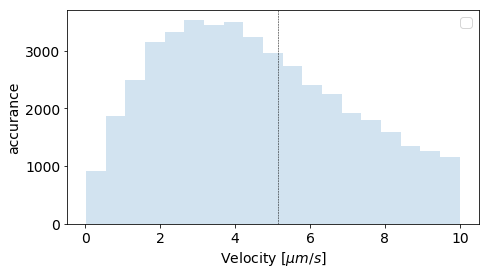

velocity particle 1 : 5.14  µm/s
velocity particle 2 : nan  µm/s


/Users/alex/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:83: RuntimeWarning: Mean of empty slice


In [105]:
newangle = np.zeros(stepsexp); newangle = particle[:,0,5].copy()    #MSD for the theoretic moving direction
diff = np.zeros(3)
for i in range(1,stepsexp):
    diff[0] = abs(newangle[i]-newangle[i-1])
    diff[1] = abs(newangle[i]-newangle[i-1]+360)
    diff[2] = abs(newangle[i]-newangle[i-1]-360)
    mini = min(diff)
    if mini != diff[0]:
        if mini == diff[1]: newangle[i:] += 360
        else: newangle[i:] -= 360
for i in range(len(endpoint)-1): newangle[endpoint[i]:] -= newangle[endpoint[i]]-newangle[endpoint[i]-1]

if noise != 0:
    check = True; i = 1
    reorwave= np.zeros((stepsexp,2))
    while check == True:
        diff = np.zeros(stepsexp-i)
        for j in range(i,stepsexp): diff[j-i] = abs(newangle[j] - newangle[j-i])  #Calculate the direction change for i steps
        mean = np.mean(diff[:stepsexp-i])   #Calculate the standard derivation
        reorwave[i,0] = i*dt
        reorwave[i,1] = mean
        if mean/57.3 >= 1: 
            check = False
            reorlen = i
        else: i += 1 
        if i == stepsexp:
            reorlen = i
            i = 666/dt
            check = False       
    reorientationtime = i*dt 
else: reorientationtime = 666

maxlength = stepsexp
particles = np.zeros((stepsexp,pnumber,8))
particles[:,:,0] = particle[:,:,0].copy()
particles[:,:,1] = particle[:,:,1].copy()
particles[:,:,2] = particle[:,:,5]
particles[:,:,0] *= 1e6
particles[:,:,1] *= 1e6

directionvector = np.zeros((maxlength,2))
movingvector = np.zeros((maxlength,2))
velocity = np.zeros((maxlength,pnumber));stepsize = np.zeros(maxlength)
velocitywithdiffusion=np.zeros((maxlength,pnumber))
velocity2 = np.zeros((maxlength,pnumber,2))
distancetocenter = np.zeros((maxlength,pnumber))

for j in range(pnumber):
    directionvector[:,0] = np.cos(particlesdisplay[:,j,2]*np.pi/180)
    directionvector[:,1] = np.sin(particlesdisplay[:,j,2]*np.pi/180)
    for i in range(1,maxlength):                           #Calc projection of the velocity in the required direction
        distancetocenter[i,j] = np.sqrt(pow(particles[i,j,0],2)+pow(particles[i,j,1],2))
        movingvector[i,0] = particlesdisplay[i,j,0]-particlesdisplay[i-1,j,0]
        movingvector[i,1] = particlesdisplay[i,j,1]-particlesdisplay[i-1,j,1]
        #stepsize[i] = abs(np.dot(directionvector[i,:], movingvector[i,:]))
        velocitywithdiffusion[i,j] = np.sqrt(pow(movingvector[i,0],2)+pow(movingvector[i,1],2))/dt 
        velocity[i,j] = velocitywithdiffusion[i,j]#stepsize[i]/dt
        distance = np.sqrt(pow(particles[i,j,0],2)+pow(particles[i,j,1],2))
        if distancetocenter[i,j] < boundaryradius*1e6:
            velocity2[i,j,0] = velocity[i,j]
            velocity2[i,j,1] = velocitywithdiffusion[i,j]
for j in range(pnumber):
    for i in range(maxlength):
        if velocity2[i,j,0] == 0: velocity2[i,j,:]=np.nan
        
wave = velocity2[:,:,0]
binwave=np.linspace(np.amin(wave[~np.isnan(wave)]),min(np.amax(wave[~np.isnan(wave)]),10),20)
fig=plt.figure(1, figsize = (7,4) )
plt.subplot(1,1,1)
for i in range(pnumber):
    wave = velocity2[:,i,0]    
    plt.hist(wave[~np.isnan(wave)], bins=binwave,alpha = 0.2)
    plt.axvline(x=np.nanmean(wave),linewidth=0.5, color = 'k',linestyle='--')
plt.xlabel('Velocity [$\mu m/s$]')
plt.ylabel('accurance')
plt.legend()
plt.tight_layout() 
plt.savefig('Velocities'+str(savename)+'.pdf', format='pdf')
plt.show() 

for i in range(pnumber): 
    wave = velocity2[:,i,0]    
    print('velocity particle',str(i+1),':',round(np.nanmean(wave),2),' µm/s')

In [106]:
particles[:,:,7] = laser[:,:,3] 
comlocation = np.zeros((maxlength,5))
for i in range(maxlength):
    if prod(particles[i,:,0]) != 0:
        comlocation[i,0] = np.nanmean(particles[i,:,0])
        comlocation[i,1] = np.nanmean(particles[i,:,1])
for i in range(maxlength):
    if comlocation[i,0] == 0:
        pre = i-1
        check = False; checknumber = i+1
        while check == False:
            if checknumber < maxlength:
                if comlocation[checknumber,0] != 0:
                    post = checknumber
                    check = True
                else: checknumber += 1
            else: check = True
        comlocation[i,:] = (comlocation[pre,:] + comlocation[post,:])/2
        
for i in range(maxlength):
    for j in range(pnumber):
        particles[i,j,6] = np.sqrt(pow(particles[i,j,0]-comlocation[i,0],2)+pow(particles[i,j,1]-comlocation[i,1],2))
    comlocation[i,2] = np.nanmean(particles[i,:,6])
    comlocation[i,3] = np.nanmean(particles[i,:,7])
    comlocation[i,4] = np.nanmean(particles[i,:,2])

meandisttocom = np.nanmean(comlocation[:,2])
meanintensity = np.nanmean(comlocation[:,3])
print('average distance to the CoM: ',meandisttocom)
print('average sensed intensity: ',meanintensity)

average distance to the CoM:  2.9820062428250096
average sensed intensity:  0.2545732688314344


In [107]:
test = np.zeros(maxlength)
for i in range(maxlength):
    count = 0
    for j in range(pnumber):
        if particles[i,j,7] > 0.2: count += 1
    if count >= 2: test[i] = 1
percentagecluster = sum(test)/maxlength
print(percentagecluster)
plotvwave = np.zeros((maxlength,pnumber))
plotintwave = np.zeros((maxlength,pnumber))
for i in range(maxlength-1): 
    plotvwave[i,:] = laser[i+1,:,4]
    plotintwave[i,:] = laser[i+1,:,3]
for k in range(pnumber):
    value = plotvwave[:,k]
    steps2 = 6
    speedhisto= np.zeros((steps2,4))    #0 - angle, 1 - velocity, 2 - counts, 3 - variance
    speedcollect=np.zeros((steps2,maxlength))
    for i in range(steps2): speedhisto[i,0] = min(value)+(i+1)/steps2*(1-min(value))
    for i in range(maxlength-1):                      #Statistics over the velocity in required direction vs the theoretical velocity
        if value[i] < speedhisto[0,0]:
            speedhisto[0,1] += velocity[i,k]
            speedcollect[0,int(speedhisto[0,2])] = velocity[i,k]
            speedhisto[0,2] += 1
        else:
            for j in range(1,steps2):
                if value[i] > speedhisto[j-1,0] and value[i] < speedhisto[j,0]:
                    speedhisto[j,1] += velocity[i,k]
                    speedcollect[j,int(speedhisto[j,2])] = velocity[i,k]
                    speedhisto[j,2] += 1
    speedhisto[:,1] /= speedhisto[:,2]
    for i in range(maxlength-1):
        for j in range(steps2):
            if speedcollect[j,i] == 0: speedcollect[j,i] = np.nan

    maxvelocity = speedhisto[-1,1]
    print('maxvelocity = ',round(maxvelocity,2))

0.56308


/Users/alex/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:31: RuntimeWarning: invalid value encountered in true_divide


maxvelocity =  7.18
maxvelocity =  0.0


/Users/alex/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:156: RuntimeWarning: divide by zero encountered in true_divide
/Users/alex/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:157: RuntimeWarning: invalid value encountered in true_divide
/Users/alex/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:120: RuntimeWarning: invalid value encountered in true_divide
/Users/alex/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:206: RuntimeWarning: divide by zero encountered in true_divide
/Users/alex/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:206: RuntimeWarning: invalid value encountered in true_divide
/Users/alex/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:212: RuntimeWarning: invalid value encountered in true_divide


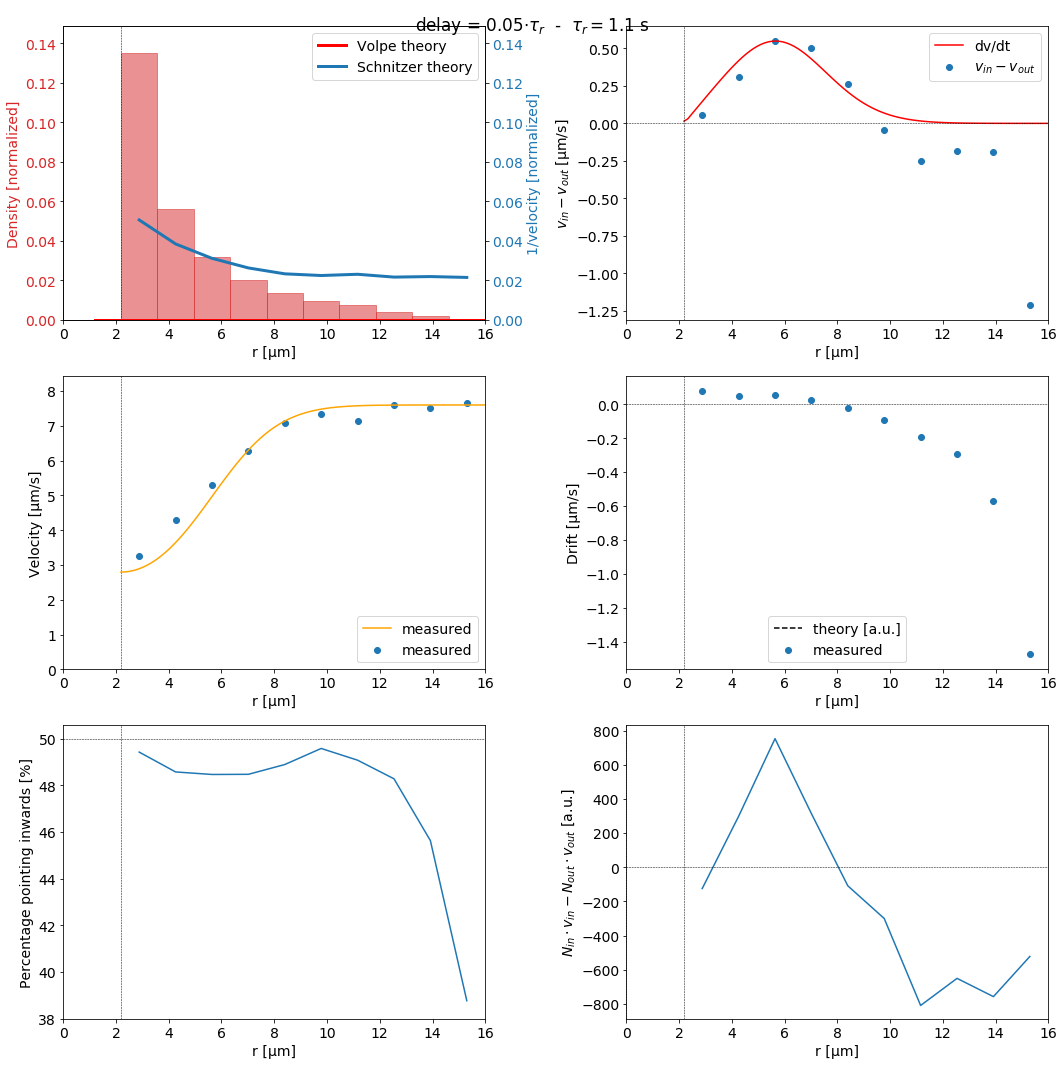

In [108]:
    savefolder ='.'
    driftdelay = 1
    distancetocenter=[]                                    #Calc velocity 
    distancetocenter=np.sqrt(pow(particlesdisplay[:,0,0],2)+pow(particlesdisplay[:,0,1],2))
    movingvector = np.zeros((maxlength,2))
    velocity = np.zeros(maxlength)
    velocitywithdiffusion=np.zeros(maxlength)
    for i in range(2,maxlength):                           #Calc projection of the velocity in the required direction
        movingvector[i,0] = particlesdisplay[i,0,0]-particlesdisplay[i-1,0,0]
        movingvector[i,1] = particlesdisplay[i,0,1]-particlesdisplay[i-1,0,1]
    velocitywithdiffusion[:] = np.sqrt(pow(movingvector[:,0],2)+pow(movingvector[:,1],2))/dt 
    velocity[:] = velocitywithdiffusion[:]
    binwave=np.linspace(min(velocity),min(max(velocitywithdiffusion),10),20)
    countin = 0
    for i in range(maxlength):
        if distancetocenter[i] < sigma*pxtomum: countin += 1
    countin /= maxlength
        
    value = particles[:,0,2]
    steps2 = 6
    speedhisto= np.zeros((steps2,4))    #0 - angle, 1 - velocity, 2 - counts, 3 - variance
    speedcollect=np.zeros((steps2,maxlength))
    for i in range(steps2): speedhisto[i,0] = min(value)+(i+1)/steps2*(1-min(value))
    for i in range(maxlength):                      #Statistics over the velocity in required direction vs the theoretical velocity
        if value[i] < speedhisto[0,0]:
            speedhisto[0,1] += velocity[i]
            speedcollect[0,int(speedhisto[0,2])] = velocity[i]
            speedhisto[0,2] += 1
        else:
            for j in range(1,steps2):
                if value[i] > speedhisto[j-1,0] and value[i] < speedhisto[j,0]:
                    speedhisto[j,1] += velocity[i]
                    speedcollect[j,int(speedhisto[j,2])] = velocity[i]
                    speedhisto[j,2] += 1
    speedhisto[:,1] /= speedhisto[:,2]
    maxvelocitymeasured = speedhisto[-1,1]
    
    startpoint = []; endpoint =[]
    if distancetocenter[0] < boundaryradius*pxtomum:
        startpoint.append(0)
        check = 0
    else: check = 1; remi = -1   
    count = 0
    for i in range(1,maxlength):
        if distancetocenter[i] > boundaryradius*pxtomum:
            if check == 0:
                remi = i
                check = 1
            count += 1
        if check == 1: 
            if distancetocenter[i] < boundaryradius*pxtomum:
                check = 0
                if remi != -1:
                    startpoint.append(i)
                    endpoint.append(remi)
                else: startpoint.append(i)
            else: count += 1   
    if check == 1: endpoint.append(remi)
    else: endpoint.append(maxlength-1)
    
    newangle = np.zeros(maxlength); newangle = particles[:,0,3].copy()    #MSD for the theoretic moving direction
    diff = np.zeros(3)
    for i in range(1,maxlength):
        diff[0] = abs(newangle[i]-newangle[i-1])
        diff[1] = abs(newangle[i]-newangle[i-1]+360)
        diff[2] = abs(newangle[i]-newangle[i-1]-360)
        mini = min(diff)
        if mini != diff[0]:
            if mini == diff[1]: newangle[i:] += 360
            else: newangle[i:] -= 360
    for i in range(len(endpoint)-1): newangle[endpoint[i]:] -= newangle[endpoint[i]]-newangle[endpoint[i]-1]

    radialdata = np.zeros((steps,15))  #0 - bins, 1 - counts, 2 - v, 3 - verr, 4 - v outwards, 5 - v outwards err
    base=(2*boundaryradius-diameter)*1e6/(steps-1)      # 6 - v inwards, 7 - v inwards err, 8 - density, 9 - v difference, 10 - v diff err, 11 - drift, 12 - drift err
    for i in range(steps): radialdata[i,0] = diameter*1e6+i*base
    averagebinposition = np.zeros(steps-1)
    for i in range(1,steps): averagebinposition[i-1] = (radialdata[i,0]+radialdata[i-1,0])/2

    step = np.zeros(maxlength); shell = np.zeros(maxlength); inout = []
    collectdrift = np.zeros((maxlength,steps))
    collectvelocity = np.zeros((maxlength,steps,3))
    count = np.zeros((steps,3))
    radialdrift = 0
    for i in range(1,maxlength):
        j = 0
        check = False
        while check == False:
            if distancetocenter[i] < radialdata[j,0] and distancetocenter[i] > radialdata[j-1,0]:
                check = True
                radialdata[j,1] += 1
                collectvelocity[int(count[j,0]),j,0] = velocity[i]
                count[j,0] += 1                        
                radialdrift = distancetocenter[i]-distancetocenter[i-driftdelay]
                collectdrift[int(count[j,0]),j] = radialdrift
                step[i] = i; shell[i] = round(averagebinposition[j-1],2)
                if radialdrift > 0:  #moving outwards
                    collectvelocity[int(count[j,1]),j,1] = velocity[i]
                    count[j,1] += 1
                    inout.append('outwards')
                if radialdrift < 0:  #moving inwards
                    collectvelocity[int(count[j,2]),j,2] = velocity[i]
                    count[j,2] += 1
                    inout.append('inwards')
            else: j += 1
            if j == steps: check = True
        if shell[i] == 0:
            step[i] = i; shell[i] = 888
            if radialdrift < 0: inout.append('inwards')
            else: inout.append('outwards')

    for i in range(1,steps): 
        radialdata[i,2] = np.mean(collectvelocity[:int(count[i,0]),i,0])    #total velocity
        radialdata[i,3] = np.nanvar(collectvelocity[:int(count[i,0]),i,0])
        radialdata[i,4] = np.mean(collectvelocity[:int(count[i,1]),i,1])    #moving outwards
        radialdata[i,5] = np.nanvar(collectvelocity[:int(count[i,1]),i,1])
        radialdata[i,6] = np.mean(collectvelocity[:int(count[i,2]),i,2])    #moving inwards
        radialdata[i,7] = np.nanvar(collectvelocity[:int(count[i,2]),i,2])
        radialdata[i,8] = radialdata[i,1]/averagebinposition[i-1]                   #density
        radialdata[i,11] = -np.mean(collectdrift[:int(count[i,0]),i])/dt
        radialdata[i,12] = np.nanvar(collectdrift[:int(count[i,0]),i])/dt
    drexp = radialdata[1,0]
    sumdensity = sum(radialdata[1:,8]*drexp)
    radialdata[1:,8] /= sumdensity                                                  
    radialdata[1:,9] = radialdata[1:,6] - radialdata[1:,4]                  #velocity difference
    radialdata[1:,10] = np.sqrt(radialdata[1:,7]**2 + radialdata[1:,5]**2)
    meandensity = sum(averagebinposition*radialdata[1:,8])
    radialdata[1:,13] = count[1:,2]*radialdata[1:,6] - count[1:,1]*radialdata[1:,4]
    radialdata[1:,14] = count[1:,2]/(count[1:,1]+count[1:,2])*100

    distmum, ddnew, velocitydist, maxdist, maxpos, diffv = calcprofile(1000,-5/4,9/8)
    test = np.gradient(velocitydist)/(distmum[1]-distmum[0])
    #base=boundaryradius*1e6/maxdist/(steps-1)      # 6 - v inwards, 7 - v inwards err, 8 - density, 9 - v difference, 10 - v diff err, 11 - drift, 12 - drift err
    #for i in range(steps): sigmawave[i] = i*base
    #averagesigmaposition = np.zeros(steps-1)
    #for i in range(1,steps): averagesigmaposition[i-1] = (sigmawave[i]+sigmawave[i-1])/2  
    schnitzer = 1/radialdata[1:,2]
    schnitzer /= np.nansum(schnitzer*drexp)
    for i in range(len(schnitzer)):
        if radialdata[1+i,2] == 0: schnitzer[i] = np.nan

    dr = distmum[1]*1e6   
    string_temp = savefolder + '/PlotRadial/'
    if not os.path.exists(string_temp): os.makedirs(string_temp) 
    fig=plt.figure(1, figsize = (15,15) )
    ax1 = plt.subplot(3,2,1)
    color = 'tab:red'
    ax1.set_xlabel(r'r [µm]')
    ax1.set_ylabel('Density [normalized]', color=color)
    bars = ax1.bar(averagebinposition, radialdata[1:,8],base, color=color,alpha = 0.5, edgecolor = color,label='Simulation')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.set_ylim([0,1.1*max(radialdata[1:,8])])
    ax1.set_xlim([0,2*boundaryradius*1e6])
    ax1.axvline(x=2*R*1e6,linewidth=0.5, color = 'k',linestyle='--')
    #ax1.axvline(x=meandensity,linewidth=0.5, color = 'k',linestyle='--',label = 'mean value')
    ax1.set_title(' ')
    theory = 1/(velocitydist**(1+delay*dt/reorientationtime))
    theory /= np.nansum(theory*dr)             
    line1 = ax1.plot(distmum,theory*1e6, color='red', linewidth = 3,label = 'Volpe theory')

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:blue'
    ax2.set_ylabel('1/velocity [normalized]', color=color)  # we already handled the x-label with ax1
    line2 = ax2.plot(averagebinposition,schnitzer, color=color, linewidth = 3,label='Schnitzer theory')
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylim([0,1.1*max(radialdata[1:,8])])
    lns = line1+line2
    labs = [l.get_label() for l in lns]
    ax1.legend(lns,labs)

    dd, vcalc = calcvelocity((2*boundaryradius-2*R),sigma,vfactor,amplitude,vmin)
    ddnew = np.zeros(len(dd))
    ddnew[:] = (dd[:] + 2*R)*1e6
    
    ax3 = plt.subplot(3,2,2)
    ax3.set_ylabel('$v_{in}-v_{out}$ [µm/s]')
    ax3.set_xlabel(r'r [µm]')
    ax3.set_title(' ')
    ax3.scatter(averagebinposition,radialdata[1:,9],label ='$v_{in} - v_{out}$')
    test = np.gradient(vcalc)/(dd[1]-dd[0])
    smoothvalue = 30
    #test2 = smooth(test,smoothvalue)
    plt.plot(ddnew,test/np.nanmax(test)*np.nanmax(radialdata[1:,9]),color='r',label = 'dv/dt')
    
    ax3.axhline(y=0,linewidth=0.5, color = 'k',linestyle='--')
    ax3.axvline(x=2*R*1e6,linewidth=0.5, color = 'k',linestyle='--')
    ax3.set_xlim([0,2*boundaryradius*1e6])
    ax3.legend()

    #distmum, ddnew, velocitydist = calcprofile(200,-5/4,9/8)
    ax4 = plt.subplot(3,2,3)
    ax4.scatter(averagebinposition, radialdata[1:,2],label='measured')
    ax4.axvline(x=2*R*1e6,linewidth=0.5, color = 'k',linestyle='--')
    #ax4.plot(distmum,2*velocitydist*maxvelocitymeasured,label='measured',color='orange')
    ax4.plot(ddnew,vcalc*np.mean(radialdata[-3:,2]),label='measured',color='orange')
    ax4.set_xlabel(r'r [µm]')
    ax4.set_ylabel('Velocity [µm/s]')
    ax4.set_xlim([0,2*boundaryradius*1e6])
    ax4.set_ylim([0,1.1*np.nanmax(radialdata[:,2])])
    ax4.legend()

    ax5 = plt.subplot(3,2,4)
    plt.scatter(averagebinposition,radialdata[1:,11],label='measured')
    ax5.axhline(y=0,linewidth=0.5, color = 'k',linestyle='--')
    ax5.axvline(x=2*R*1e6,linewidth=0.5, color = 'k',linestyle='--')
    drifttheory = calcdrifttheory(velocitydist,distmum,reorientationtime,delay*dt,dr)
    plt.plot(distmum,drifttheory/drifttheory[2]*radialdata[1,11],'k--',label='theory [a.u.]')
    ax5.set_xlabel(r'r [µm]')
    ax5.set_ylabel('Drift [µm/s]')
    ax5.set_xlim([0,2*boundaryradius*1e6])
    ax5.legend()

    percentage2 = count[:,2]/(count[:,1]+count[:,2])*100
    ax6 = plt.subplot(3,2,5)
    plt.plot(averagebinposition,radialdata[1:,14])
    plt.xlabel(r'r [µm]')
    plt.ylabel('Percentage pointing inwards [%]')
    plt.axvline(x=2*boundaryradius*1e6,linewidth=0.5, color = 'k',linestyle='--')
    plt.axhline(y=50,linewidth=0.5, color = 'k',linestyle='--')
    ax6.axvline(x=2*R*1e6,linewidth=0.5, color = 'k',linestyle='--')
    plt.ylim([0.98*np.nanmin(radialdata[1:,14]),1.02*np.nanmax(radialdata[1:,14])])
    plt.xlim([0,2*boundaryradius*1e6])

    ax7 = plt.subplot(3,2,6)
    plt.plot(averagebinposition,radialdata[1:,13])
    plt.axhline(y=0,linewidth=0.5, color = 'k',linestyle='--')
    ax7.axvline(x=2*R*1e6,linewidth=0.5, color = 'k',linestyle='--')
    plt.xlabel(r'r [µm]')
    plt.ylabel(r'$N_{in} \cdot v_{in} - N_{out} \cdot v_{out}$ [a.u.]')
    plt.xlim([0,2*boundaryradius*1e6])
    plt.axvline(x=boundaryradius*pxtomum,linewidth=0.5, color = 'k',linestyle='--')

    plt.suptitle('delay = '+str(round(delay*dt/reorientationtime,2))+r'$\cdot \tau_{r}$  -  $\tau_{r} = $'+str(round(reorientationtime,1))+' s')
    plt.tight_layout() 
    plt.savefig(string_temp+'Density layout'+str(int(noise))+' - '+str(int(delay))+'.pdf', format='pdf')
    plt.show()    

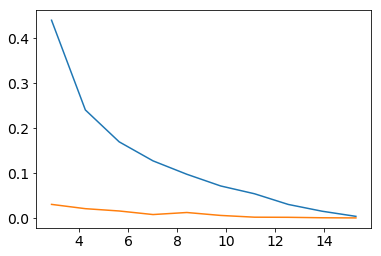

In [115]:
plt.plot(averagebinposition,radialdata[1:,8]*radialdata[1:,2])
plt.plot(averagebinposition,radialdata[1:,8]*(limitedvin[1:]-limitedvout[1:]))


/Users/alex/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:74: RuntimeWarning: invalid value encountered in true_divide
/Users/alex/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:75: RuntimeWarning: invalid value encountered in true_divide
/Users/alex/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:76: RuntimeWarning: invalid value encountered in true_divide
/Users/alex/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:77: RuntimeWarning: invalid value encountered in true_divide


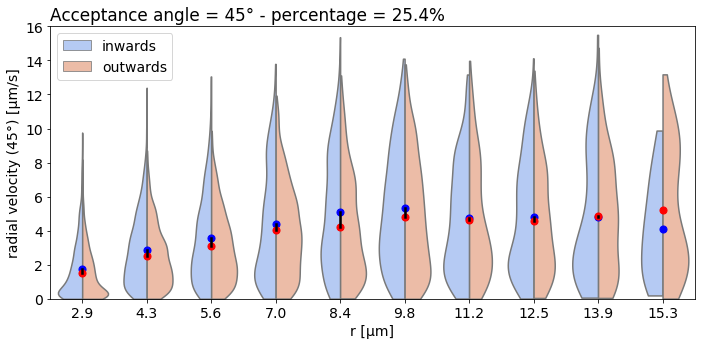

In [110]:
    #distmum, ddnew, velocitydist = calcprofile(20,-5/4,9/8)
    radialdistance = np.zeros(maxlength)
    radialdistance[:] = np.sqrt(pow(particlesdisplay[:,0,0],2)+pow(particlesdisplay[:,0,1],2))
    driftdelay = 1   
    diffv = np.gradient(velocitydist)/(distmum[1]-distmum[0])
    maxpos = np.argmax(diffv)
    maxdist = distmum[maxpos]
    
    radialdist = np.zeros((steps,3))       #0 - radius, 1 - effective radial drift, 2 - counts
    base=(2*boundaryradius-diameter)*1e6/(steps-1)      # 6 - v inwards, 7 - v inwards err, 8 - density, 9 - v difference, 10 - v diff err, 11 - drift, 12 - drift err
    for i in range(steps): radialdist[i,0] = diameter*1e6+i*base
    for i in range(1, steps):
        radialdist[i,1] = round((radialdist[i,0]+radialdist[i-1,0])/2,1)
        #radialdist[i,2] = round(radialdist[i,1]/maxdist,1)     
    angletocenter = np.zeros(maxlength)
    for i in range(maxlength):
        a = [-np.cos((particles[i,0,3])*np.pi/180),-np.sin((particles[i,0,3])*np.pi/180)]
        b = [particlesdisplay[i,0,0],particlesdisplay[i,0,1]]
        angletocenter[i] = np.arccos(np.dot(a,b)/(vectorlength(a)*vectorlength(b)))*180/np.pi     
    radialdrift = np.zeros(maxlength)
    radialstats = np.zeros((steps,5))   #0 - radial distance, 1 - counts inwards, 2 - drift inwards
                                         #3 - counts outwards, 4 - drift inwards  
    limitedradialstats = np.zeros((steps,5))   #0 - radial distance, 1 - counts inwards, 2 - drift inwards
                                         #3 - counts outwards, 4 - drift inwards
    radialstats[:,0] = limitedradialstats[:,0] = radialdist[:,1]     
    allradialdata = np.zeros((maxlength,5))      #0 - not used, 1 - shell, 2 - in or out, 3 - radial drift
                                                 #4 - angletocenter
    limitedradialdata = np.zeros((maxlength,5))  #0 - step, 1 - shell, 2 - in or out, 3 - radial drift
    
    checkangle = 45
    count = 0
    inouttest = []; limitedinout = []  
    point = max(driftdelay,2)
    for i in range(point,maxlength):
        for j in range(1,steps):
            if radialdistance[i] < radialdist[j,0] and radialdistance[i] > radialdist[j-1,0]:
                check = (radialdistance[i]-radialdistance[i-driftdelay])/dt
                radialdrift[i] = (radialdistance[i]-radialdistance[i-driftdelay])/dt
                allradialdata[i,1] = radialdist[j,1]
                allradialdata[i,3] = abs(radialdrift[i])
                allradialdata[i,4] = angletocenter[i]
                if check <= 0:
                    radialstats[j,1] += 1
                    radialstats[j,2] += abs(radialdrift[i])
                    inouttest.append('inwards')
                    allradialdata[i,2] = 0
                    if angletocenter[i] < checkangle:
                        limitedradialstats[j,1] += 1
                        limitedradialstats[j,2] += abs(radialdrift[i])
                        limitedradialdata[count,0] = i
                        limitedradialdata[count,1] = radialdist[j,1]
                        limitedradialdata[count,2] = 0
                        limitedradialdata[count,3] = abs(radialdrift[i])
                        limitedradialdata[i,4] = angletocenter[i]
                        limitedinout.append('inwards')
                        count += 1
                else:
                    radialstats[j,3] += 1
                    radialstats[j,4] += radialdrift[i]
                    allradialdata[i,2] = 1
                    inouttest.append('outwards')
                    if angletocenter[i] > 180 - checkangle:
                        limitedradialstats[j,3] += 1
                        limitedradialstats[j,4] += abs(radialdrift[i])
                        limitedradialdata[count,0] = i
                        limitedradialdata[count,1] = radialdist[j,1]
                        limitedradialdata[count,2] = 1
                        limitedradialdata[count,3] = abs(radialdrift[i])
                        limitedradialdata[i,4] = angletocenter[i]
                        limitedinout.append('outwards')
                        count += 1
                j=steps
        if allradialdata[i,1] == 0: allradialdata[i,2] = 888
    radialstats[:,2] /= radialstats[:,1]
    radialstats[:,4] /= radialstats[:,3]
    limitedradialstats[:,2] /= limitedradialstats[:,1]
    limitedradialstats[:,4] /= limitedradialstats[:,3]
    
    vin = np.zeros(steps);vout = np.zeros(steps); limitedvin = np.zeros(steps); limitedvout = np.zeros(steps)
    for i in range(1,steps):
        vin[i] = round(radialstats[i,2],2)
        vout[i] = round(radialstats[i,4],2)
        limitedvin[i] = round(limitedradialstats[i,2],2)
        limitedvout[i] = round(limitedradialstats[i,4],2)
        
    alldata1 = list(zip(arange(point,maxlength),allradialdata[point:,1],inouttest[point:],allradialdata[point:,3]))
    alldata2 = pd.DataFrame(data = alldata1, columns=['step', 'distance', 'direction', 'velocity'])
    alldata3 = alldata2.replace(888, 'outside')
    limitedalldata1 = list(zip(arange(point,count),limitedradialdata[point:count,1],limitedinout[point:count],limitedradialdata[point:count,3]))
    limitedalldata2 = pd.DataFrame(data = limitedalldata1, columns=['step', 'distance', 'direction', 'velocity'])
    limitedalldata3 = limitedalldata2.replace(888, 'outside')
    
    fig=plt.figure(1, figsize = (10,5) )
    ax4 = plt.subplot(1,1,1)
    ax4 = sns.violinplot(x="distance", y="velocity", hue="direction", hue_order = ['inwards','outwards'], order = radialdist[1:,1],
                            data=limitedalldata3, palette="coolwarm", split=True, scale="count", cut=0, inner=None)#,bw=.2, scale_hue=False
    ax4.set_ylabel('radial velocity ('+str(checkangle)+'°) [µm/s]')
    ax4.set_xlabel(r'r [µm]')
    numwave=np.linspace(0,len(vin[1:]),len(limitedvin[1:]),endpoint=False)
    for i in range(1,len(vin[1:])):
        ax4.plot([numwave[i-1],numwave[i-1]],[limitedvin[i],limitedvout[i]],color='k',linewidth=2.5)
    ax4.scatter(numwave,limitedvin[1:],s=50,c='b')#,label = 'v in')
    ax4.scatter(numwave,limitedvout[1:],s=50,c='r')#,label = 'v out')
    ax4.set_ylim([0,min(max(velocity),16)])
    ax4.set_title('Acceptance angle = '+str(checkangle)+'° - percentage = '+str(round(count/maxlength*100,1))+'%',loc='left')
    plt.legend(loc='upper left')
    plt.tight_layout() 
    plt.savefig('Velocity in and out - limited'+str(int(noise))+' - '+str(int(delay))+'.pdf', format='pdf')
    plt.show()

In [111]:
v45 = np.zeros((steps,3))
v45[1:,0] = numwave
v45[1:,1] = limitedvin[1:]
v45[1:,2] = limitedvout[1:]

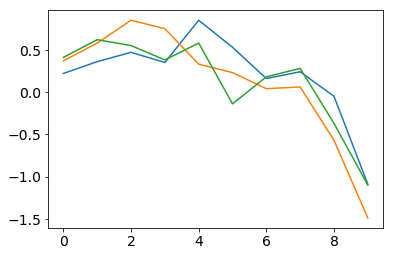

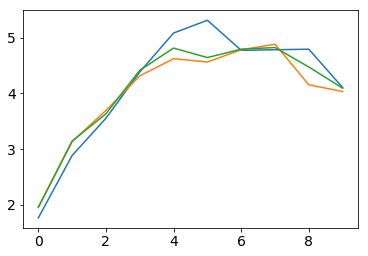

In [112]:
plt.plot(v45[1:,0],v45[1:,1]-v45[1:,2])
plt.plot(v90[1:,0],v90[1:,1]-v90[1:,2])
plt.plot(v180[1:,0],v180[1:,1]-v45[1:,2])
plt.show()

plt.plot(v45[1:,0],v45[1:,1])
plt.plot(v90[1:,0],v90[1:,1])
plt.plot(v180[1:,0],v180[1:,1])
plt.show()

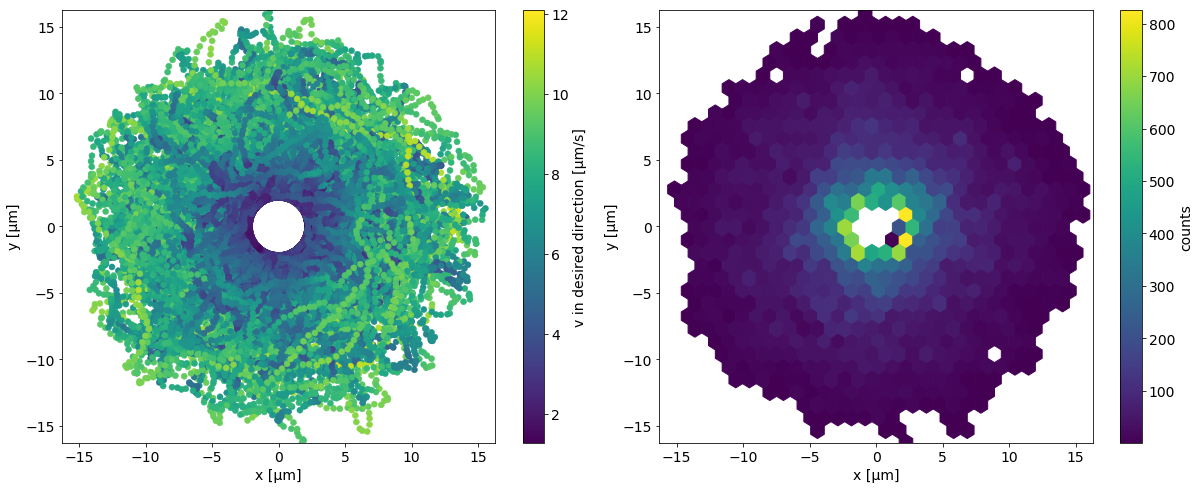

In [113]:
factor = 2.04
smoothvalue = 20
smoothit = smooth(velocity,smoothvalue)
xmin = -factor*boundaryradius*1e6#x.min()
xmax = factor*boundaryradius*1e6#x.max()
ymin = -factor*boundaryradius*1e6#y.min()
ymax = factor*boundaryradius*1e6#y.max()
x = particlesdisplay[smoothvalue:maxlength-smoothvalue,0,0]
y = particlesdisplay[smoothvalue:maxlength-smoothvalue,0,1]
v = smoothit[smoothvalue:maxlength-smoothvalue]
gridsizevalue = 30
fig, axs = plt.subplots(ncols=2, figsize=(17,7), sharex='all')
fig.subplots_adjust(hspace=0.1, left=0.05, right=0.95)
ax = axs[0]
circle2 = plt.Circle((0, 0), boundaryradius*pxtomum, color='k', fill=False)
ax.add_artist(circle2)
im = ax.scatter(x,y,c=v,linewidths=0.5)
ax.set_xlabel('x [µm]')
ax.set_ylabel('y [µm]')
ax.tick_params(axis='y')
#plt.title('Particle position')
ax.axis('equal')
ax.set_xlim(xmin,xmax)
ax.set_ylim(ymin,ymax)
cb = fig.colorbar(im, ax=ax)
cb.set_label('v in desired direction [µm/s]')
x = particlesdisplay[:,0,0]
y = particlesdisplay[:,0,1]
#https://matplotlib.org/2.0.0/examples/pylab_examples/hexbin_demo.html
ax = axs[1]
hb = ax.hexbin(x, y, gridsize=gridsizevalue,mincnt=0.01)
ax.axis([xmin, xmax, ymin, ymax])
circle2 = plt.Circle((0, 0), boundaryradius*pxtomum, color='w', fill=False)
ax.add_artist(circle2)
cb = fig.colorbar(hb, ax=ax)
cb.set_label('counts')
ax.set_xlabel('x [µm]')
ax.set_ylabel('y [µm]')
ax.axis('equal')
ax.set_xlim(xmin,xmax)
ax.set_ylim(ymin,ymax)
plt.tight_layout() 
#plt.savefig('Path of the particle colored'+str(printnum)+'.pdf', format='pdf')
#plt.savefig('Path of the particle colored'+str(printnum)+'.svg', format='svg')
plt.show()

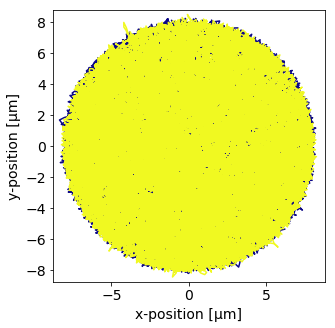

In [114]:
colorwave = cm.plasma(np.linspace(0, 1, pnumber))
fig=plt.figure(1, figsize = (5,5) )
ax = plt.subplot(1,1,1)
ax.set_aspect('equal')
for i in range(pnumber):
    circle2 = plt.Circle((particle[k,i,0]*1e6,particle[k,i,1]*1e6), diameter/2*1e6, color='grey', fill=True)
    ax.add_artist(circle2)
    ax.plot(particle[:,i,0]*1e6,particle[:,i,1]*1e6,color=colorwave[i],zorder=2)
circle2 = plt.Circle((0, 0), boundaryradius*1e6, color='k', fill=False)
ax.add_artist(circle2)
plt.xlabel('x-position [µm]')
plt.ylabel('y-position [µm]')
value = 1.1 * boundaryradius*1e6
ax.set_xlim([-value,value])
ax.set_ylim([-value,value])
plt.show()